In [2]:
#####################
# Basic Boilerplate #
#####################

import os  
import sys
import time

# Type Hints (Optional)
from typing import Optional, Tuple, Union, TypeVar, List
#from torch import Tensor
import numpy.typing as npt

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

########################
# NLP and ML Libraries #
########################

from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import string
import re
import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer, wordpunct_tokenize

####################
# Big Data Modules #
####################

import dask
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
#from dask_ml.model_selection import train_test_split
from dask.distributed import Client, progress

import joblib

#################
# Audio Modules #
#################

import librosa
from IPython import display
from IPython.display import Audio

In [3]:
############################################################################
# Verifying Correct Python Interpreter / Environment and Working Directory #
############################################################################

print(sys.executable)
print(os.getcwd())
# print(torch.cuda.is_available()) # Check GPU Availability

C:\Users\rzamb\Documents\UMD\651_Big_Data\finalProjectTest2\.venv\Scripts\python.exe
C:\Users\rzamb\Documents\UMD\651_Big_Data\finalProjectTest2


# Loading Common Voice Sub Set with Spark

In [4]:
# Common voice path 
PATH = "C:/Users/rzamb/Documents/UMD/651_Big_Data/finalProjectTest2/cv-corpus-15.0-delta-2023-09-08-es/cv-corpus-15.0-delta-2023-09-08/es/other.tsv"

In [5]:
schema={'client_id':str,
       'path':str,
       'sentence':str,
       'up_votes':float,	
       'down_votes':float,	
       'age':str, 
       'gender':str,	
       'accents':str,	
       'variant':str,	
       'locale':str,	
       'segment':str
}

In [6]:
# Load Common Voice Sub Set (For Testing)
common_voice_raw = dd.read_csv(PATH,sep='\t',header=0,dtype=schema) 

In [7]:
common_voice_raw.head(n=5)

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,9c33dde21d22851bbb6ae15a60c78e563f722658a87ace...,common_voice_es_38024600.mp3,La corona fue usada durante toda la coronación...,0.0,0.0,<NA>,<NA>,<NA>,<NA>,es,<NA>
1,9c33dde21d22851bbb6ae15a60c78e563f722658a87ace...,common_voice_es_38024601.mp3,Noruega clasificó a un jugador basado en el ra...,0.0,0.0,<NA>,<NA>,<NA>,<NA>,es,<NA>
2,9c33dde21d22851bbb6ae15a60c78e563f722658a87ace...,common_voice_es_38024602.mp3,La sede de condado es Morgan.,0.0,0.0,<NA>,<NA>,<NA>,<NA>,es,<NA>
3,9c33dde21d22851bbb6ae15a60c78e563f722658a87ace...,common_voice_es_38024603.mp3,"Dispone de sala de espera, venta de billetes, ...",0.0,0.0,<NA>,<NA>,<NA>,<NA>,es,<NA>
4,9c33dde21d22851bbb6ae15a60c78e563f722658a87ace...,common_voice_es_38024604.mp3,Es recordado como un ejemplo de espíritu depor...,0.0,0.0,<NA>,<NA>,<NA>,<NA>,es,<NA>


In [8]:
# It seems that variant has no information in this subset
len(common_voice_raw.loc[common_voice_raw["variant"].isna()])
#common_voice_raw.dropna(subset=['variant']).head(15)

8635

In [9]:
# Dropping unnecesary columns
common_voice = common_voice_raw.drop(['up_votes','down_votes','age','gender','variant','locale','segment'], axis=1)

In [10]:
# Dropping rows in column = 'accents' with <NA> values
common_voice_base = common_voice.dropna(subset=['accents'])

In [11]:
# Check the number of complete rows available in this dataset
print(len(common_voice_base))

7114


In [12]:
# Next step is generating a column with the full path to the audio files
AUDIO_FILES_PATH = "C:/Users/rzamb/Documents/UMD/651_Big_Data/finalProjectTest2/cv-corpus-15.0-delta-2023-09-08-es/cv-corpus-15.0-delta-2023-09-08/es/clips/"

In [13]:
common_voice_base['full_path'] = AUDIO_FILES_PATH+common_voice_base['path']

In [14]:
path_test = common_voice_base.iloc[:,4].head(1)

In [15]:
# Making sure path to audio files are generated in a correct format
path_test.values

<ArrowStringArray>
['C:/Users/rzamb/Documents/UMD/651_Big_Data/finalProjectTest2/cv-corpus-15.0-delta-2023-09-08-es/cv-corpus-15.0-delta-2023-09-08/es/clips/common_voice_es_38028025.mp3']
Length: 1, dtype: string

In [16]:
# To simplyfy the custom function implememntation a wrapper function was created. It discards the sample rate
# output from librosa and returns only the waveform. This avoids populating two columns in one operation using zip(*args)
def librosa_load_wrap(path:str)->np.ndarray:
    """Load an audio file as a floating point time series.

    Audio will be automatically resampled to the given rate
    (default ``sr=22050``).

    To preserve the native sampling rate of the file, use ``sr=None``.

    Parameters
    ----------
    path : string, int, pathlib.Path, soundfile.SoundFile, audioread object, or file-like object
        path to the input file.

        Any codec supported by `soundfile` or `audioread` will work.

        Any string file paths, or any object implementing Python's
        file interface (e.g. `pathlib.Path`) are supported as `path`.

        If the codec is supported by `soundfile`, then `path` can also be
        an open file descriptor (int) or an existing `soundfile.SoundFile` object.

        Pre-constructed audioread decoders are also supported here, see the example
        below.  This can be used, for example, to force a specific decoder rather
        than relying upon audioread to select one for you.
        
    Returns
    -------
    y : np.ndarray [shape=(n,) or (..., n)]
        audio time series. Multi-channel is supported.

    Examples
    --------
    >>> # Load an ogg vorbis file
    >>> filename = librosa.ex('trumpet')
    >>> y = librosa.load(filename)
    >>> y
    array([-1.407e-03, -4.461e-04, ..., -3.042e-05,  1.277e-05],
          dtype=float32)    
    """
    
    y,_ = librosa.load(path,duration=20) # Discards sample rate wich defaults to 22050
                                         # Limiting the utterances' audio to 20 seconds which is the instructor's recommended length 
    return y

In [17]:
# Because the dataframe seems to not support array-like structures the column with the full path is extractes as a dask array. 
# Loading the waveform, generating the mel spectrogram as wel as the MFCC features will be generated/extracted outside the dataframe 
# using dask arrrayswhenever is possible
full_path = common_voice_base['full_path'].to_dask_array()

C:\Users\rzamb\Documents\UMD\651_Big_Data\finalProjectTest2\.venv\Lib\site-packages\dask\dataframe\core.py:3828: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(


In [18]:
full_path.compute().shape

(7114,)

In [19]:
# The loading of the waveform will be timed to estimate processing time of the full dataset. Worst case scenario is about 3hrs 
# based on the timem obtained
start_time = time.time()
waveform = tuple(librosa_load_wrap(pth) for pth in full_path.compute())
print(time.time()-start_time)

63.88456606864929


In [20]:
# Verifying the generated mel spectrogram looks correct. Notice each m
print(len(waveform))
print(waveform[0].shape)
print(waveform[1].shape)
print(waveform[2].shape)
print(type(waveform[0]))

7114
(105576,)
(71442,)
(113514,)
<class 'numpy.ndarray'>


In [21]:
def get_mel_spectrogram(waveform:np.ndarray)->np.ndarray:
    """Compute a mel-scaled spectrogram.

    If a spectrogram input ``S`` is provided, then it is mapped directly onto
    the mel basis by ``mel_f.dot(S)``.

    If a time-series input ``y, sr`` is provided, then its magnitude spectrogram
    ``S`` is first computed, and then mapped onto the mel scale by
    ``mel_f.dot(S**power)``.

    By default, ``power=2`` operates on a power spectrum.

    Parameters
    ----------
    y : np.ndarray [shape=(..., n)] or None
        audio time-series. Multi-channel is supported.

    Returns
    -------
    S : np.ndarray [shape=(..., n_mels, t)]
        Mel spectrogram
    """

    # Hard Coded Variables
    win_length = None
    n_fft = 1024
    win_length = None
    hop_length = 512
    n_mels = 128 # Originally 256
    sample_rate = 22050
    
    melSpec = librosa.feature.melspectrogram(
                                    y=waveform,
                                    sr=sample_rate,
                                    n_fft=n_fft,
                                    hop_length=hop_length,
                                    win_length=win_length,
                                    center=True, 
                                    pad_mode="reflect",
                                    power=2.0, 
                                    n_mels=n_mels, 
                                    norm="slaney", 
                                    htk=True)

    return melSpec

In [22]:
start_time = time.time()
mel_spec = tuple(get_mel_spectrogram(wav) for wav in waveform)
print(time.time()-start_time)

63.925371170043945


In [23]:
def get_mfcc_features(melSpectrogram:np.ndarray)->np.ndarray:
    """
    Mel-frequency cepstral coefficients (MFCCs)

    .. warning:: If multi-channel audio input ``y`` is provided, the MFCC
        calculation will depend on the peak loudness (in decibels) across
        all channels.  The result may differ from independent MFCC calculation
        of each channel.

    Parameters
    ----------
    y : np.ndarray [shape=(..., n,)] or None
        audio time series. Multi-channel is supported..

    Returns
    -------
    M : np.ndarray [shape=(..., n_mfcc, t)]
        MFCC sequence

    """
    
    # Hard Coded Variables
    n_mfcc = 128 # originally 256
    
    mfcc = librosa.feature.mfcc(S=librosa.core.spectrum.power_to_db(melSpectrogram), n_mfcc=n_mfcc, dct_type=2, norm="ortho")
    
    return mfcc

In [24]:
start_time = time.time()
mfcc = tuple(get_mfcc_features(mel) for mel in mel_spec)
print(time.time()-start_time)

6.000720739364624


In [25]:
print(len(mfcc))
print(mfcc[0].shape)
print(mfcc[1].shape)
print(mfcc[2].shape)
print(type(mfcc[0]))

7114
(128, 207)
(128, 140)
(128, 222)
<class 'numpy.ndarray'>


In [26]:
da.asarray(mfcc[0])

dask.array<array, shape=(128, 207), dtype=float32, chunksize=(128, 207), chunktype=numpy.ndarray>

In [27]:
da.asarray(mfcc[1])

dask.array<array, shape=(128, 140), dtype=float32, chunksize=(128, 140), chunktype=numpy.ndarray>

In [28]:
# The next step is to get the dimension of the varying axis in the mfcc feature tuple
start_time = time.time()
dim_mfcc = tuple(item.shape[1] for item in mfcc)
print(time.time()-start_time)

0.002997875213623047


In [29]:
dim_mfcc[:5]

(207, 140, 222, 264, 292)

In [30]:
print(max(dim_mfcc))
print(min(dim_mfcc))
print(sum(dim_mfcc)/len(dim_mfcc))

452
73
220.82794489738544


(array([0.000e+00, 0.000e+00, 1.000e+00, 4.500e+01, 2.110e+02, 5.360e+02,
        8.150e+02, 1.085e+03, 1.189e+03, 1.165e+03, 8.300e+02, 5.470e+02,
        3.400e+02, 1.700e+02, 8.500e+01, 4.600e+01, 2.900e+01, 1.800e+01,
        2.000e+00]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.,
        275., 300., 325., 350., 375., 400., 425., 450., 475.]),
 <BarContainer object of 19 artists>)

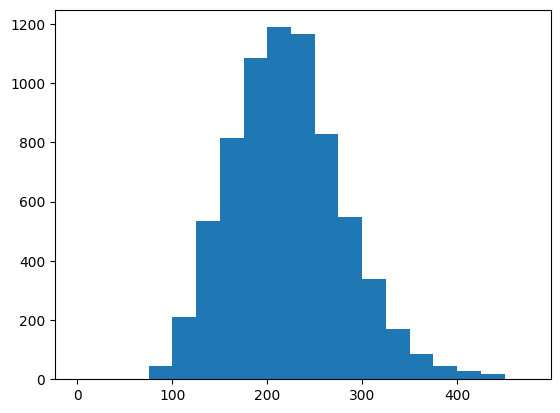

In [31]:
plt.hist(np.array(dim_mfcc), bins=[0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475])

Even after limiting the length of the utterings to 20 secods we still get the same distributions. This means that I will not cut tensors only pad the shorter ones

In [32]:
mfcc[1]

array([[-7.2699188e+02, -7.2699188e+02, -6.9769305e+02, ...,
        -7.0221991e+02, -7.0949847e+02, -7.2699188e+02],
       [ 0.0000000e+00,  0.0000000e+00,  3.6885376e+01, ...,
         2.9419117e+01,  2.2602362e+01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  2.5256424e+01, ...,
         1.7117237e+01,  1.7699703e+01,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  9.8795223e-01, ...,
        -3.5609484e-02, -1.4766598e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  3.0526066e-01, ...,
         9.7556400e-01, -2.3318768e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -9.1531754e-02, ...,
         9.8066998e-01, -1.3835907e-01,  0.0000000e+00]], dtype=float32)

In [33]:
dim_diff = 452 - np.array(dim_mfcc)

In [34]:
dim_diff[:5]

array([245, 312, 230, 188, 160])

In [35]:
# npad is a tuple of (n_before, n_after) for each dimension
npad_vec = tuple(((0, 0), (0, pad)) for pad in dim_diff)

In [36]:
npad_vec[:5]

(((0, 0), (0, 245)),
 ((0, 0), (0, 312)),
 ((0, 0), (0, 230)),
 ((0, 0), (0, 188)),
 ((0, 0), (0, 160)))

In [37]:
# Getting padded mfcc fature tensors
start_time = time.time()
padded_mfcc = tuple(np.pad(arr, pad_width=npad, mode='constant', constant_values=0) for arr,npad in zip(mfcc,npad_vec))
print(time.time()-start_time)

2.295114517211914


In [38]:
start_time = time.time()
dim_padded_mfcc = tuple(item.shape[1] for item in padded_mfcc)
print(time.time()-start_time)

0.0010027885437011719


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7114.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.,
        275., 300., 325., 350., 375., 400., 425., 450., 475.]),
 <BarContainer object of 19 artists>)

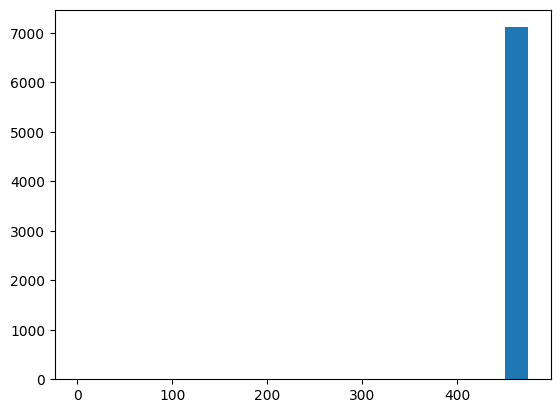

In [39]:
plt.hist(np.array(dim_padded_mfcc), bins=[0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475])

In [40]:
print(padded_mfcc[0].shape)
print(padded_mfcc[1].shape)
print(padded_mfcc[2].shape)

(128, 452)
(128, 452)
(128, 452)


In [41]:
mfcc[1]

array([[-7.2699188e+02, -7.2699188e+02, -6.9769305e+02, ...,
        -7.0221991e+02, -7.0949847e+02, -7.2699188e+02],
       [ 0.0000000e+00,  0.0000000e+00,  3.6885376e+01, ...,
         2.9419117e+01,  2.2602362e+01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  2.5256424e+01, ...,
         1.7117237e+01,  1.7699703e+01,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  9.8795223e-01, ...,
        -3.5609484e-02, -1.4766598e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  3.0526066e-01, ...,
         9.7556400e-01, -2.3318768e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -9.1531754e-02, ...,
         9.8066998e-01, -1.3835907e-01,  0.0000000e+00]], dtype=float32)

In [42]:
padded_mfcc[1]

array([[-7.2699188e+02, -7.2699188e+02, -6.9769305e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  3.6885376e+01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  2.5256424e+01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  9.8795223e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  3.0526066e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -9.1531754e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [43]:
# Now we convert the data back to dask
mfcc_data = da.asarray(padded_mfcc)
mfcc_data

dask.array<array, shape=(7114, 128, 452), dtype=float32, chunksize=(579, 128, 452), chunktype=numpy.ndarray>

In [44]:
# Now that we have the MFCC data we need to pull the accent unique values and codify them into numbers then generate the target array
accent_class = common_voice_base['accents'].unique().compute()
accent_class

0                                España: Islas Canarias
1     España: Norte peninsular (Asturias, Castilla y...
2                                                México
3     España: Sur peninsular (Andalucia, Extremadura...
4                                        Islas Baleares
5     España: Centro-Sur peninsular (Madrid, Toledo,...
6                                           El Salvador
7                                                  Peru
8     Rioplatense: Argentina, Uruguay, este de Boliv...
9     Caribe: Cuba, Venezuela, Puerto Rico, Repúblic...
10                                              peneano
11    Andino-Pacífico: Colombia, Perú, Ecuador, oest...
12                                      América central
13                                 Chileno: Chile, Cuyo
Name: accents, dtype: string

In [45]:
accents_encode = {}
for i,accent in enumerate(accent_class):
    accents_encode[accent] = i

accents_decode = {}
for i,accent in enumerate(accent_class):
    accents_encode[i] = accent

In [46]:
accents_encode['España: Islas Canarias']

0

In [47]:
accents_encode.get('España: Islas Canarias')

0

In [48]:
meta_df = pd.Series(dtype='int', name='encoded_accents')
common_voice_base['encoded_accents'] = common_voice_base['accents'].apply(lambda acc: accents_encode.get(acc), meta=meta_df)

In [49]:
common_voice_base.head(5)

,client_id,path,sentence,accents,full_path,encoded_accents
25,4cdf8d8e32155d337b9a928486bb044b63442f1126cdfb...,common_voice_es_38028025.mp3,Es de estilo renacentista.,España: Islas Canarias,C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,0
26,4cdf8d8e32155d337b9a928486bb044b63442f1126cdfb...,common_voice_es_38028026.mp3,Dengeki Hime,España: Islas Canarias,C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,0
27,4cdf8d8e32155d337b9a928486bb044b63442f1126cdfb...,common_voice_es_38028027.mp3,Bruce H. McCormick fue el líder del proyecto.,España: Islas Canarias,C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,0
28,4cdf8d8e32155d337b9a928486bb044b63442f1126cdfb...,common_voice_es_38028028.mp3,En lugar de conseguir algún tipo de venganza p...,España: Islas Canarias,C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,0
29,4cdf8d8e32155d337b9a928486bb044b63442f1126cdfb...,common_voice_es_38028029.mp3,"Éste, en contraste, es un artista reputado que...",España: Islas Canarias,C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,0


In [50]:
common_voice_base[common_voice_base['accents'] == 'Chileno: Chile, Cuyo'].head(5)

,client_id,path,sentence,accents,full_path,encoded_accents
7008,a1f17bd32c284ad4c0861c6a73836f4cf0359cdc3976f5...,common_voice_es_38354104.mp3,Las últimas tecnologías se anuncian como inmun...,"Chileno: Chile, Cuyo",C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,13
7009,a1f17bd32c284ad4c0861c6a73836f4cf0359cdc3976f5...,common_voice_es_38354106.mp3,De su unión con García nació Migue García.,"Chileno: Chile, Cuyo",C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,13
7010,a1f17bd32c284ad4c0861c6a73836f4cf0359cdc3976f5...,common_voice_es_38354107.mp3,Es el patrono de la iglesia y del distrito de ...,"Chileno: Chile, Cuyo",C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,13
7011,a1f17bd32c284ad4c0861c6a73836f4cf0359cdc3976f5...,common_voice_es_38354108.mp3,"Jacob el profeta tuvo doce hijos, y Dios hizo ...","Chileno: Chile, Cuyo",C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,13
7012,a1f17bd32c284ad4c0861c6a73836f4cf0359cdc3976f5...,common_voice_es_38354110.mp3,Los premios suelen ser presentados por bellas ...,"Chileno: Chile, Cuyo",C:/Users/rzamb/Documents/UMD/651_Big_Data/fina...,13


In [51]:
targets = common_voice_base['encoded_accents'].compute().to_numpy()
target_arr = da.asarray(targets)
target_arr

dask.array<array, shape=(7114,), dtype=int64, chunksize=(7114,), chunktype=numpy.ndarray>

In [52]:
mfcc_data

dask.array<array, shape=(7114, 128, 452), dtype=float32, chunksize=(579, 128, 452), chunktype=numpy.ndarray>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_data, target_arr,test_size=0.30, random_state=42)

C:\Users\rzamb\Documents\UMD\651_Big_Data\finalProjectTest2\.venv\Lib\site-packages\sklearn\utils\__init__.py:184: PerformanceWarning: Slicing with an out-of-order index is generating 354 times more chunks
  return array[key] if axis == 0 else array[:, key]
C:\Users\rzamb\Documents\UMD\651_Big_Data\finalProjectTest2\.venv\Lib\site-packages\sklearn\utils\__init__.py:184: PerformanceWarning: Slicing with an out-of-order index is generating 152 times more chunks
  return array[key] if axis == 0 else array[:, key]


In [54]:
X_train

dask.array<getitem, shape=(4979, 128, 452), dtype=float32, chunksize=(4, 128, 452), chunktype=numpy.ndarray>

In [55]:
y_train

dask.array<getitem, shape=(4979,), dtype=int64, chunksize=(4979,), chunktype=numpy.ndarray>

In [56]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

In [57]:
grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)

In [1]:
# #client = Client()
# client = Client(processes=False, threads_per_worker=4,
#                 n_workers=1, memory_limit='2GB')

In [59]:
# start_time = time.time()

# with joblib.parallel_backend('dask'):
#     grid_search.fit(X_train.compute(), y_train.compute())

# print(time.time()-start_time)

In [58]:
xx = X_train.compute()
yy = y_train.compute()

In [60]:
# start_time = time.time()
# grid_search.fit(xx, yy)
# print(time.time()-start_time)

In [ ]:
start_time = time.time()

with joblib.parallel_backend('dask'):
    grid_search.fit(xx, yy)

print(time.time()-start_time)

In [ ]:
pd.DataFrame(grid_search.cv_results_).head()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

In [65]:
sentences = common_voice_base['sentence'].compute().tolist()
sentence_lengths = []
for sent in sentences:
    try:
        sentence_lengths.append(len(sent))
    except:
        sentence_lengths.append(0)
print(max(sentence_lengths))
print(min(sentence_lengths))
print(sum(sentence_lengths)/len(sentence_lengths))

124
0
61.415096991847065


(array([  15.,  130.,  296.,  592.,  910., 1172., 1345., 1343.,  862.,
         349.,   84.,   14.,    2.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130.]),
 <BarContainer object of 13 artists>)

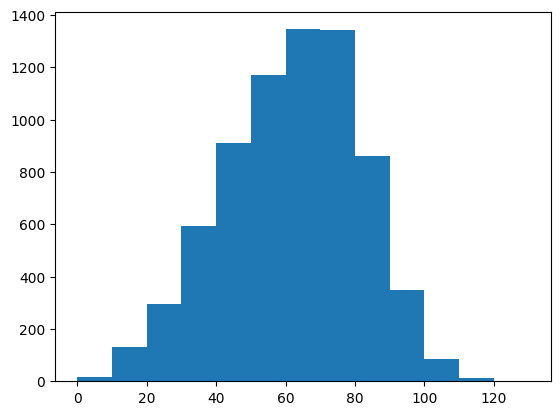

In [67]:
plt.hist(np.array(sentence_lengths), bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])

In [261]:
X, y = make_classification(n_samples=1000, random_state=0)

In [262]:
X = da.asarray(X)
y = da.asarray(y)

In [265]:
with joblib.parallel_backend('dask'):
    grid_search.fit(X.compute(), y.compute())

In [266]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.140924,0.013254,0.025197,0.004169,0.001,rbf,True,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
1,0.140233,0.016872,0.023156,0.001520,0.001,rbf,False,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': False}",0.502994,0.501502,0.501502,0.501999,0.000704,41
2,0.077901,0.003988,0.008780,0.003934,0.001,poly,True,"{'C': 0.001, 'kernel': 'poly', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
3,0.094517,0.008950,0.006942,0.001420,0.001,poly,False,"{'C': 0.001, 'kernel': 'poly', 'shrinking': Fa...",0.502994,0.501502,0.501502,0.501999,0.000704,41
4,0.119207,0.003276,0.009717,0.001421,0.001,sigmoid,True,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.502994,0.501502,0.501502,0.501999,0.000704,41


# Experiments

In [189]:
d = {'col1': [[1.0, 2.0], [3.0, 4.0]], 'col2': [[5, 6], [7, 8]]}
df = dd.from_pandas(pd.DataFrame(data=d),npartitions=2)
df.compute()

,col1,col2
0,"[1.0, 2.0]","[5, 6]"
1,"[3.0, 4.0]","[7, 8]"


In [190]:
df.dtypes

col1    string[pyarrow]
col2    string[pyarrow]
dtype: object

In [191]:
d = {'col1': [np.array([1.0, 2.0]), np.array([3.0, 4.0])], 'col2': [np.array([5, 6]), np.array([7, 8])], 'col3':['string1','string2']}
df = dd.from_pandas(pd.DataFrame(data=d),npartitions=2)
df.compute()

,col1,col2,col3
0,[1. 2.],[5 6],string1
1,[3. 4.],[7 8],string2


In [192]:
df.dtypes

col1    string[pyarrow]
col2    string[pyarrow]
col3    string[pyarrow]
dtype: object

In [193]:
np.array([1,2])

array([1, 2])

In [194]:
def func1(string:str)->int:
    return 1

In [195]:
func1('rererer')

1

In [196]:
#df['test1'],df['test2'] = zip(*df['col3'].apply(lambda path: func1(path), meta={'test1':'str','test2':'int'}))
df['test1'] = df['col3'].apply(lambda path: func1(path), meta=pd.Series(dtype='int', name='test1'))

In [197]:
df.compute()

,col1,col2,col3,test1
0,[1. 2.],[5 6],string1,1
1,[3. 4.],[7 8],string2,1


In [198]:
df.dtypes

col1     string[pyarrow]
col2     string[pyarrow]
col3     string[pyarrow]
test1              int32
dtype: object

In [218]:
def func2(arr:np.ndarray)->np.ndarray:
    new_arr = arr + np.array([10.0,10.0])
    return new_arr

In [219]:
func2(np.array([1,1]))

array([11., 11.])

In [208]:
df['test2'] = df['col1'].apply(lambda arr: func2(arr), meta=pd.Series(dtype='string[pyarrow]', name='test2'))
#dtype='pyarrow.from_numpy_dtype(np.dtype("float32"))'

In [217]:
#df.compute()

In [221]:
b = np.array([1,1])
b

array([1, 1])

In [222]:
x = da.from_array(b)

In [223]:
x

dask.array<array, shape=(2,), dtype=int32, chunksize=(2,), chunktype=numpy.ndarray>

In [224]:
x.compute()

array([1, 1])

In [225]:
y = da.asarray(b)

In [226]:
y

dask.array<array, shape=(2,), dtype=int32, chunksize=(2,), chunktype=numpy.ndarray>

In [228]:
(y == x).compute()

array([ True,  True])

In [229]:
z = x.compute()

In [230]:
z

array([1, 1])

In [231]:
type(z)

numpy.ndarray

In [232]:
type(y)

dask.array.core.Array

In [233]:
c = np.ones((3, 3))
c

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [235]:
x2 = da.asarray(c) 

In [236]:
x2

dask.array<array, shape=(3, 3), dtype=float64, chunksize=(3, 3), chunktype=numpy.ndarray>

In [237]:
x2.compute()

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [238]:
d = np.ones((3, 3, 2))
d

array([[[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]]])

In [239]:
x3 = da.asarray(d)

In [240]:
x3

dask.array<array, shape=(3, 3, 2), dtype=float64, chunksize=(3, 3, 2), chunktype=numpy.ndarray>

In [241]:
x3.compute()

array([[[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]]])

In [244]:
x4 = da.asarray(np.ones((3, 3, 2))*2)

In [245]:
x5 = x4+x3

In [246]:
x5

dask.array<add, shape=(3, 3, 2), dtype=float64, chunksize=(3, 3, 2), chunktype=numpy.ndarray>

In [247]:
x5.compute()

array([[[3., 3.],
        [3., 3.],
        [3., 3.]],

       [[3., 3.],
        [3., 3.],
        [3., 3.]],

       [[3., 3.],
        [3., 3.],
        [3., 3.]]])

In [293]:
df = dd.from_pandas(pd.DataFrame({'A': [da.asarray(np.array([1,2,3])),
                                        da.asarray(np.array([1,2,3])),
                                        da.asarray(np.array([1,2,3]))], 'B':[4,5,6]}),npartitions=2)

In [294]:
df.compute()

,A,B
0,"dask.array<array, shape=(3,), dtype=int32, chu...",4
1,"dask.array<array, shape=(3,), dtype=int32, chu...",5
2,"dask.array<array, shape=(3,), dtype=int32, chu...",6


In [295]:
df.dtypes

A    string[pyarrow]
B              int64
dtype: object

In [297]:
df['A'].compute()

0    dask.array<array, shape=(3,), dtype=int32, chu...
1    dask.array<array, shape=(3,), dtype=int32, chu...
2    dask.array<array, shape=(3,), dtype=int32, chu...
Name: A, dtype: string

In [217]:
#df['A'] + da.asarray(np.array([1,1,1]))

In [90]:
a = np.ones((4, 3))
a

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [96]:
da.asarray(a)

dask.array<array, shape=(4, 3), dtype=float64, chunksize=(4, 3), chunktype=numpy.ndarray>

In [94]:
# npad is a tuple of (n_before, n_after) for each dimension
npad = ((0, 0), (0, 1))

In [95]:
b = np.pad(a, pad_width=npad, mode='constant', constant_values=0)
b

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.]])

In [97]:
da.asarray(b)

dask.array<array, shape=(4, 4), dtype=float64, chunksize=(4, 4), chunktype=numpy.ndarray>

In [107]:
b[:,:3]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [143]:
names = ['Bob','Alice','Foo','Baz']
numbers = [1,2,3,4]
mapped = zip(names,numbers)

In [146]:
for name,num in zip(names,numbers):
    print("Name: ",name)
    print("Number: ",num)

Name:  Bob
Number:  1
Name:  Alice
Number:  2
Name:  Foo
Number:  3
Name:  Baz
Number:  4


In [148]:
["The name is {} and the number is {}".format(name,num) for name,num in zip(names,numbers)]

['The name is Bob and the number is 1',
 'The name is Alice and the number is 2',
 'The name is Foo and the number is 3',
 'The name is Baz and the number is 4']